# Analysis notebook for DRIT paired image-to-image
Jesse Wilson (2021) jesse.wilson@colostate.edu

In [56]:
# imports, dependencies, and notebook-wide dependencies
import sys
if '../src' not in sys.path:
    sys.path.append('../src')

from options import TestOptions, TrainOptions
from dataset import dataset_single, dataset_unpair
from model import DRIT
from random import randint

import torch
import matplotlib.pyplot as plt
import numpy as np

options_string ="""--dataroot /top/projects/WilsonGroup/MRA_grant/aim1/data/20210617_ongoing/FOV150 \
--name rcm2shg_drit_20210702_test20210708 \
--resume ../results/rcm2shg_drit_20210702/01199.pth \
--gpu 0
--input_dim_a 1
--input_dim_b 1
--no_flip"""

# Load a dataset and saved model
Code here has been copied from ../src/train.py and ../src/test.py and modified to expose the objects we need.

In [2]:
def getDataset(opts):
    print('\n--- load dataset ---')
    if opts.a2b:
        dataset = dataset_single(opts, 'A', opts.input_dim_a)
    else:
        dataset = dataset_single(opts, 'B', opts.input_dim_b)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=opts.nThreads)
    
    return dataset, loader

In [3]:
def getDataset(opts):
    print('\n--- load dataset ---')
    dataset = dataset_unpair(opts)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=opts.nThreads)
    
    return dataset, loader

In [4]:
def getModel(opts):
    print('\n--- load model ---')
    model = DRIT(opts)
    model.setgpu(opts.gpu)
    model.resume(opts.resume, train=False)
    model.eval()
    
    return model

In [196]:
parser = TrainOptions()
opts = parser.parse(options_string.split())

opts.phase = "test"
dataset, loader = getDataset(opts)
opts.phase = "train"
model = getModel(opts)


--- load options ---
batch_size: 2
concat: 1
crop_size: 216
d_iter: 3
dataroot: /top/projects/WilsonGroup/MRA_grant/aim1/data/20210617_ongoing/FOV150
dis_norm: None
dis_scale: 3
dis_spectral_norm: False
display_dir: ../logs
display_freq: 1
gpu: 0
img_save_freq: 5
input_dim_a: 1
input_dim_b: 1
lr_policy: lambda
model_save_freq: 10
nThreads: 8
n_ep: 1200
n_ep_decay: 600
name: rcm2shg_drit_20210702_test20210708
no_display_img: False
no_flip: True
no_ms: False
phase: train
resize_size: 256
result_dir: ../results
resume: ../results/rcm2shg_drit_20210702/01199.pth

--- load dataset ---
A: 190, B: 190 images

--- load model ---


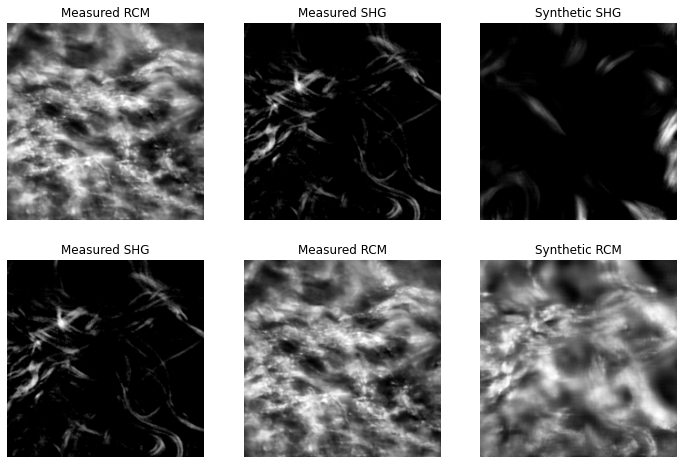

In [206]:
# select a random image
ind = randint(0,len(dataset.A)-1)
imgA = dataset.load_img(dataset.A[ind],opts.input_dim_a).unsqueeze(0)
imgB = dataset.load_img(dataset.B[ind],opts.input_dim_b).unsqueeze(0)

# perform image translation
with torch.no_grad():
    outA = model.test_forward(imgA.cuda())
    outB = model.test_forward(imgB.cuda(), a2b=False)

# plot the results
plt.figure(figsize=[12,8])

plt.subplot(231)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')
plt.subplot(232)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.title('Measured SHG')
plt.axis('off')
plt.subplot(233)
plt.imshow(np.squeeze(outA.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG')

plt.subplot(234)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured SHG')
plt.subplot(235)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')
plt.subplot(236)
plt.imshow(np.squeeze(outB.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM')

plt.show()

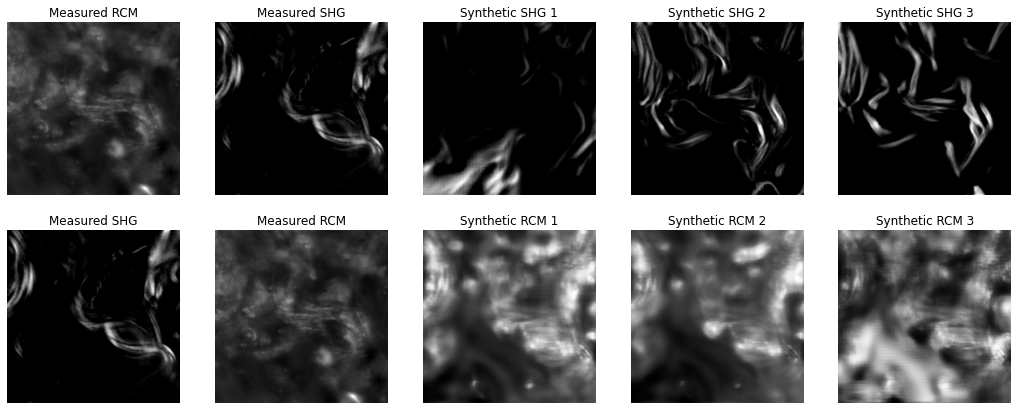

In [287]:
# select a random image
ind = randint(0,len(dataset.A)-1)
imgA = dataset.load_img(dataset.A[ind],opts.input_dim_a).unsqueeze(0)
imgB = dataset.load_img(dataset.B[ind],opts.input_dim_b).unsqueeze(0)

# perform image translation, make a few possibilities
with torch.no_grad():
    outA1 = model.test_forward(imgA.cuda())
    outA2 = model.test_forward(imgA.cuda())
    outA3 = model.test_forward(imgA.cuda())
    
    outB1 = model.test_forward(imgB.cuda(), a2b=False)
    outB2 = model.test_forward(imgB.cuda(), a2b=False)
    outB3 = model.test_forward(imgB.cuda(), a2b=False)

# plot the results
plt.figure(figsize=[18,7])

plt.subplot(2,5,1)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')
plt.subplot(2,5,2)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.title('Measured SHG')
plt.axis('off')
plt.subplot(2,5,3)
plt.imshow(np.squeeze(outA1.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG 1')
plt.subplot(2,5,4)
plt.imshow(np.squeeze(outA2.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG 2')
plt.subplot(2,5,5)
plt.imshow(np.squeeze(outA3.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic SHG 3')

plt.subplot(2,5,6)
plt.imshow(np.squeeze(imgB.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured SHG')
plt.subplot(2,5,7)
plt.imshow(np.squeeze(imgA.numpy()),cmap='gray')
plt.axis('off')
plt.title('Measured RCM')
plt.subplot(2,5,8)
plt.imshow(np.squeeze(outB1.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM 1')
plt.subplot(2,5,9)
plt.imshow(np.squeeze(outB2.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM 2')
plt.subplot(2,5,10)
plt.imshow(np.squeeze(outB3.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.title('Synthetic RCM 3')

plt.show()

In [247]:
e = model.enc_c.forward(imgA.cuda(),imgB.cuda())
print(torch.mean(torch.abs(e[0]-e[1])))

a = model.enc_a.forward(imgA.cuda(), imgB.cuda())
print(torch.mean(torch.abs(a[0]-a[1])))

tensor(0.3642, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.8941, device='cuda:0', grad_fn=<MeanBackward0>)


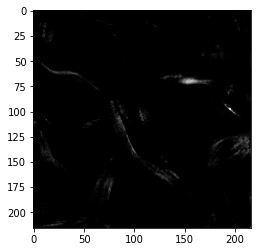

In [275]:
# try generating a panel of rcm2shg translations and averaging
n_trials = 100

with torch.no_grad():
    for i in range(n_trials):
        out = model.test_forward(imgA.cuda())
        
        if i == 0:
            outs = out
        else:
            outs = torch.cat((outs,out),0)
            
out = torch.median(outs,0).values

plt.imshow(np.squeeze(out.cpu().numpy()),cmap='gray')
plt.show()

In [257]:
out.values

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -0.9999, -1.0000,  ..., -0.9980, -0.9918, -0.9965],
         [-0.9999, -1.0000, -0.9994,  ..., -0.9988, -0.9964, -0.9946],
         [-0.9997, -0.9993, -0.9987,  ..., -0.9807, -0.9838, -0.9397]]],
       device='cuda:0')